# 라이브러리 import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rc # 폰트
from datetime import datetime
import time
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
# datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')

path = 'D:\\바탕 화면\\카트라이더\\1027\\'

## 컬럼 설명
- cnt_match matchid 기준 건수  
- cnt_account 사용자 기준 건수 (retire된 유저 포함)  
- no_retire_SUM_time : 매치 타임을 전부 합한 값 (retire된 유저 포함)   
- no_retire_SUM_time.1 : no_retire_SUM_time에서 retire된 유저를 제외한 평균값  
- cnt_retire_player : 리타이어된 유저  
- cnt_player : 전체 유저  
- percent_retire : 리타이어된 유저 비율 

# KPI 데이터로 분포 확인
- kpi 데이터는 총 28일치 (4주)

In [2]:
kpi = pd.read_csv(path + "00-single_speed_09121010-KPI.csv")
kpi.head(3)

,map_name,cnt_match,cnt_user,cnt_retire_user,percent_retire,SUM_match_time,AVG_match_time
0,빌리지 운하,10325,215222.0,70792.0,32.8925,1.809054e+09,51731.585016
1,트랙 9,7067,12807.0,3766.0,29.4058,4.570849e+08,55451.285454
2,노르테유 허공의 갈림길,5343,8232.0,1794.0,21.7930,3.461118e+08,58982.931152


In [3]:
# 결측치 제거

kpi.isnull().sum()
kpi = kpi.dropna()

## cnt_match와 cnt_user 의 상관성 확인

In [4]:
kpi.corr()

,cnt_match,cnt_user,cnt_retire_user,percent_retire,SUM_match_time,AVG_match_time
cnt_match,1.000000,0.810465,0.795089,0.014546,0.452078,-0.022628
cnt_user,0.810465,1.000000,0.986246,0.040084,0.461586,-0.014883
cnt_retire_user,0.795089,0.986246,1.000000,0.089275,0.478131,-0.003321
percent_retire,0.014546,0.040084,0.089275,1.000000,0.090667,0.114503
SUM_match_time,0.452078,0.461586,0.478131,0.090667,1.000000,0.802449
AVG_match_time,-0.022628,-0.014883,-0.003321,0.114503,0.802449,1.000000


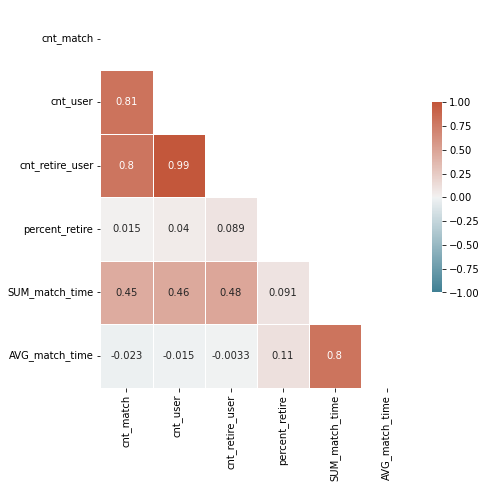

In [5]:
from numpy import arange
tmp = kpi.corr()

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(7,7) )

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(tmp, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# 히트맵 팔레트 색상 불러오기
cmap = sns.diverging_palette(220, 20, as_cmap=True)
# 히트맵을 그린다
sns.heatmap(tmp ,
            annot = True,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .5},# 컬러바 크기 절반으로 줄이기
            cmap = cmap,
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )
plt.show()

# cnt_match 기준 상위/하위 트랙 설정하기

## 사용하지 않을(삭제할) 데이터 기준

In [6]:
# 하루에 한 번도 플레이 하지 않은 맵 (4일 동안 최소 4번, n일동안 최소 n번) 은 삭제하기로 함

kpi_for_match = kpi
cnt_match_df = kpi_for_match.loc[kpi.cnt_match > 28]

In [7]:
# 28회가 전체의 몇 퍼센트 정도에 위치하는지 확인
# 145개 / 전체 319개 맵
kpi_for_match.loc[kpi_for_match.cnt_match <= 28]

print(len(kpi_for_match.loc[kpi_for_match.cnt_match <= 28])/len(kpi_for_match) * 100)   # 약 하위 45.45%를 다 날려버리고 시작하게 됨

45.45454545454545


In [8]:
# 이상치 확인 함수
def detect_num(df):
    for i in df.select_dtypes(exclude='object').columns:
        Q1 = df[i].quantile(0.25)
        Q3 = df[i].quantile(0.75)
        IQR = Q3 - Q1
        print( i, df[i][ (df[i]>Q3 + IQR*1.5) | (df[i]<Q1 - IQR*1.5) ].count() )
        print( i, 'Q1 이하: ', df[i][ (df[i]<Q1 - IQR*1.5) ].count() )
        print( i, 'Q3 이상: ', df[i][ (df[i]>Q3 + IQR*1.5) ].count() )
        print( i, '이상치의 전체 비율: ', round(df[i][ (df[i]>Q3 + IQR*1.5) | (df[i]<Q1 - IQR*1.5) ].count() / df[i].count(), 5) * 100 )
        print("="*36)

In [9]:
# 전체 매치수

cnt_match_df.cnt_match.sum()

79949

In [10]:
# 사용률 백분위 컬럼 생성

cnt_match_df['percentage'] = round(cnt_match_df.cnt_match/cnt_match_df.cnt_match.sum()*100, 3)

In [11]:
# cnt_match값 사분위수 확인하기

Q1 = cnt_match_df['cnt_match'].quantile(0.25)
Q2 = cnt_match_df['cnt_match'].quantile(0.5)
Q3 = cnt_match_df['cnt_match'].quantile(0.75)

print('Q1 : ', Q1)
print('Q2 : ', Q2)
print('Q3 : ', Q3)

Q1 :  59.25
Q2 :  128.0
Q3 :  482.75


In [12]:
# 이상치 갯수 확인

detect_num(cnt_match_df)

cnt_match 11
cnt_match Q1 이하:  0
cnt_match Q3 이상:  11
cnt_match 이상치의 전체 비율:  6.322
cnt_user 29
cnt_user Q1 이하:  0
cnt_user Q3 이상:  29
cnt_user 이상치의 전체 비율:  16.667
cnt_retire_user 27
cnt_retire_user Q1 이하:  0
cnt_retire_user Q3 이상:  27
cnt_retire_user 이상치의 전체 비율:  15.517
percent_retire 6
percent_retire Q1 이하:  0
percent_retire Q3 이상:  6
percent_retire 이상치의 전체 비율:  3.4479999999999995
SUM_match_time 28
SUM_match_time Q1 이하:  0
SUM_match_time Q3 이상:  28
SUM_match_time 이상치의 전체 비율:  16.092000000000002
AVG_match_time 6
AVG_match_time Q1 이하:  0
AVG_match_time Q3 이상:  6
AVG_match_time 이상치의 전체 비율:  3.4479999999999995
percentage 11
percentage Q1 이하:  0
percentage Q3 이상:  11
percentage 이상치의 전체 비율:  6.322


In [13]:
# # cnt_match에 log 씌워보기

# cnt_match_df['log_cnt'] = np.log1p(cnt_match_df['cnt_match'])
# test_match_df = cnt_match_df[['map_name', 'cnt_match', 'log_cnt']]

In [14]:
# # LOG
# # Q1 - Q2
# # Q3 이상

# # 로그 씌운 cnt값 사분위수 확인하기

# log_Q1 = test_match_df['log_cnt'].quantile(0.25)
# log_Q2 = test_match_df['log_cnt'].quantile(0.5)
# log_Q3 = test_match_df['log_cnt'].quantile(0.75)

# print('Q1 : ', log_Q1)
# print('Q2 : ', log_Q2)
# print('Q3 : ', log_Q3)

# print('median : ', cnt_match_df.log_cnt.median())

## 시각화로 데이터 분포 확인하기  
- cnt_match에 대한 boxplot 출력
- 이상치 분포 확인 필요


<AxesSubplot:>

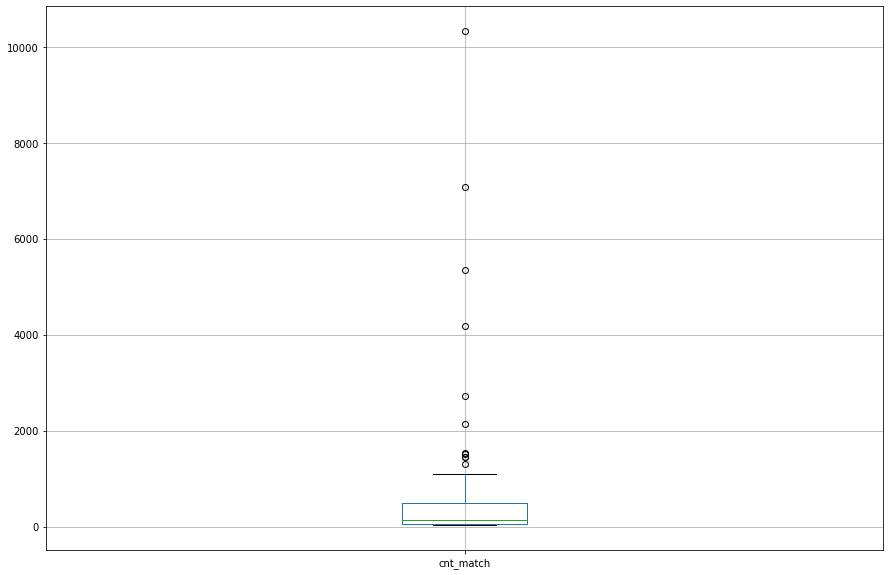

In [15]:
# 이상치 11개

cnt_match_df[['cnt_match']].boxplot(figsize = (15, 10))

## cnt_match 기준 상위 / 하위 결정 기준
- cnt_match 28 이하 플레이 된 데이터 삭제
- cnt_match 29 초과 플레이 된 데이터 기준 상위 n%를 추출하기로 결정함

### 상위 트랙 기준 정하기

In [16]:
# (1) 상위 트랙 기준 정하기 (상위 25%)
# Q3 이상, 상위 테이블로 만들기
# 482.75이상, 44건

upper_Q3_df = cnt_match_df.loc[cnt_match_df.cnt_match >= Q3]
print(len(upper_Q3_df))
#print(Q3)upper_Q3_df
display(upper_Q3_df)

44


,map_name,cnt_match,cnt_user,cnt_retire_user,percent_retire,SUM_match_time,AVG_match_time,percentage
0,빌리지 운하,10325,215222.0,70792.0,32.8925,1.809054e+09,51731.585016,12.914
1,트랙 9,7067,12807.0,3766.0,29.4058,4.570849e+08,55451.285454,8.839
2,노르테유 허공의 갈림길,5343,8232.0,1794.0,21.7930,3.461118e+08,58982.931152,6.683
3,코리아 제주 해오름 다운힐,4183,25468.0,8688.0,34.1134,4.962177e+08,68794.905171,5.232
4,빌리지 고가의 질주,2714,30486.0,10096.0,33.1168,7.808868e+08,116969.266327,3.395
5,비치 해변 드라이브,2140,24805.0,11344.0,45.7327,6.537340e+08,128865.355805,2.677
6,사막 버려진 오아시스,1543,7449.0,3560.0,47.7916,2.198743e+08,104354.199336,1.930
7,메이플 헤네시스 공원,1507,20226.0,7559.0,37.3727,3.790161e+08,98933.980684,1.885
8,빌리지 남산,1457,19645.0,5778.0,29.4121,4.193928e+08,109673.854864,1.822
9,메이플 리스항구 언덕길,1452,19738.0,8864.0,44.9083,3.164022e+08,92515.272515,1.816


### 하위 트랙 기준 정하기

In [17]:
# (1) 하위 트랙 기준 정하기, 하위 25%
# Q1 미만을 확인, 44개
# 29 ~ 59

lower_Q1_df = cnt_match_df.loc[cnt_match_df.cnt_match < Q1]
len(lower_Q1_df)
# display(lower_Q1_df)

44

아래는 하위 트랙 기준을 정하기 위해 논의했던 내용들  
box-plot 기준으로 데이터를 추출할까 고민하였으나, 통상적 의미의 '하위' 를 추출하는 게 낫겠다고 판단하였음

In [18]:
# # (2) 하위 트랙 기준 정하기
# # Q1 ~ Q2 사이를 확인하기
# # Q1 이상, Q2 미만, 43개
# # 60 ~ 125


# lower_Q1Q2_df = cnt_match_df.loc[(cnt_match_df.cnt_match >= Q1) & (cnt_match_df.cnt_match < Q2)]
# len(lower_Q1Q2_df)
# # display(lower_Q1Q2_df)

In [19]:
# # (2) 하위 트랙 기준 정하기
# # Q2 미만을 확인하기
# # Q2 미만, 87개



# lower_Q2_df = cnt_match_df.loc[cnt_match_df.cnt_match < Q2]
# # lower_Q2_df.head(25)


In [20]:
# # (3) 하위 트랙 기준 정하기
# # Q2 기준 위 아래로 12.5%씩 출력

# Q2_5 = cnt_match_df['cnt_match'].quantile(0.375)
# Q3_5 = cnt_match_df['cnt_match'].quantile(0.625)

# between_Q2_df = cnt_match_df.loc[(cnt_match_df.cnt_match >= Q2_5) & (cnt_match_df.cnt_match < Q3_5)]
# print(len(between_Q2_df))
# # display(between_Q2_df)

In [21]:
# 상위 트랙 리스트 중 최하위열
display(upper_Q3_df.tail(1))

# 하위 트랙 리스트 중 최상위열
display(lower_Q1_df.head(1))

,map_name,cnt_match,cnt_user,cnt_retire_user,percent_retire,SUM_match_time,AVG_match_time,percentage
43,노르테유 익스프레스,491,3799.0,1706.0,44.9066,145690742.0,155985.805139,0.614


,map_name,cnt_match,cnt_user,cnt_retire_user,percent_retire,SUM_match_time,AVG_match_time,percentage
131,신화 오딘의 궁전,59,484.0,156.0,32.2314,16143666.0,136810.728814,0.074


In [22]:
# 저장하기

upper_Q3_df.to_csv(path + 'upper_match_map.csv', index=False, encoding = 'utf-8')
lower_Q1_df.to_csv(path + 'lower_match_map.csv', index=False, encoding = 'utf-8')

## cnt_user 상위 / 하위 결정 기준

### 기본 데이터 분포 확인

In [24]:
kpi.cnt_user.describe()

# 하위 25%가 78명
# 우리 데이터는 28일치 데이터
# 한 매치당 몇 명의 플레이어가 플레이 하는지 평균 / 중위값을 알아내보자
# 그래서 한 매치당 평균 플레이어 수가 나올테니, 거기서 * 28을 해볼까


# 한 매치당 중위수 기준 2명 정도 들어가는 것으로 파악됨
# 그 맵이 하루에 한 번 플레이 됐다면, 최소 2명 * 28이니 56명은 있어야 하는데
# 56보다 적다면 하루에 한 번도 플레이 하지 않은 것으로 해석할 수 있지 않을까?

count       319.000000
mean       2821.912226
std       12915.210623
min           4.000000
25%          78.500000
50%         187.000000
75%        1047.500000
max      215222.000000
Name: cnt_user, dtype: float64

In [25]:
# # 맵당 플레이 한 유저 수 파악하기

# fig, ax = plt.subplots(figsize = (10, 8))

# sns.set_style('whitegrid')
# sns.histplot(kpi.cnt_user, kde = True)

# plt.title('user distribution by map')

### 매치 당 유저 수 파악

In [27]:
# 매치당 유저 수 파악하기
# 평균, 중위수, 최빈값 확인
# 필요하다면 시각화 해서 확인

# 각 맵당 플레이 한 유저 수 테이블 새로 생성하여 import
find_user_cnt = pd.read_csv(path + "00-single_speed_match_id_Player.csv")
find_user_cnt.head(3)

print('산술평균 :', find_user_cnt.cnt_user.mean())    
print('중위수 :', find_user_cnt.cnt_user.median())    

In [ ]:
from collections import Counter
list3_count = Counter(find_user_cnt.cnt_user) #각 속성별 갯수 구하기
list3_count.most_common(1) 

In [ ]:
from collections import Counter
list3_count = Counter(find_user_cnt.cnt_user) #각 속성별 갯수 구하기
list3_count.most_common(3)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 8))

sns.set_style('whitegrid')
sns.histplot(find_user_cnt.cnt_user,bins = range(0,10,1), kde = True)

plt.title('user distribution by match')

### 사용하지 않을 데이터 기준

In [ ]:
# 중위수 기준 매치당 2명의 플레이어가 배정됨
# 하루에 한 건의 매치가 발생했다면, 최소 56명의 플레이어가 해당 맵을 플레이 했어야 함
# 따라서, 28일 동안 플레이 한 유저 수가 56명 이하인 경우는 제거하기로 함

# 하루에 한 번도 플레이 하지 않은 맵 (4일 동안 최소 4번, n일동안 최소 n번) 은 삭제하기로 함

kpi_for_user = kpi
cnt_user_df = kpi_for_user.loc[kpi.cnt_user > 56]

In [ ]:
cnt_user_df  # 전체 274건

In [ ]:
# 로그 씌우기 전 cnt_user값 사분위수 확인하기

user_Q1 = cnt_user_df['cnt_user'].quantile(0.25)
user_Q2 = cnt_user_df['cnt_user'].quantile(0.5)
user_Q3 = cnt_user_df['cnt_user'].quantile(0.75)

print('Q1 : ', user_Q1)
print('Q2 : ', user_Q2)
print('Q3 : ', user_Q3)

print('- ' * 36)
print('max : ', cnt_user_df.cnt_user.max())
print('min : ', cnt_user_df.cnt_user.min())

print(cnt_user_df.count())

In [ ]:
# 이상치 확인하기
# cnt_user 기준 이상치는 46개, 전부 Q3 이상에서 발생
# 이상치의 전체 비율은 16.788
# -> 로그 씌워서 파악해야 할 것 같음

# detect_num(cnt_user_df)

### 상위 트랙 기준 정하기

In [ ]:
# 이상치 46개
# 로그를 씌우지 않으면 match와 같은 기준을 설정할 수 없을 것이라고 판단

#cnt_user_df[['cnt_user']].boxplot(figsize = (15, 10))

In [ ]:
# (1) 로그 씌우지 않은 데이터 - 상위 트랙 기준 정하기
# Q3 이상, 상위 테이블로 만들기
# 1416.0이상, 69건

user_upper_Q3_df = cnt_user_df.loc[cnt_user_df.cnt_user >= user_Q3]
# len(user_upper_Q3_df)
# display(user_upper_Q3_df)

In [ ]:
# cnt_match에 log 씌워보기

cnt_user_df['log_cnt'] = np.log1p(cnt_user_df['cnt_user'])
test_df = cnt_user_df[['map_name', 'cnt_user', 'log_cnt']]
test_df

In [ ]:
log_user_Q1 = test_df['log_cnt'].quantile(0.25)
log_user_Q2 = test_df['log_cnt'].quantile(0.5)
log_user_Q3 = test_df['log_cnt'].quantile(0.75)

print('Q1 : ', log_user_Q1)
print('Q2 : ', log_user_Q2)
print('Q3 : ', log_user_Q3)

In [ ]:
detect_num(test_df)

In [ ]:
log_user_upper_Q3_df = test_df.loc[test_df.log_cnt >= log_user_Q3]
len(log_user_upper_Q3_df)
display(log_user_upper_Q3_df)

### 효진요청
- cnt_user가 2072를 초과한 트랙의 수 
- 한 매치당 플레이어 중위수(2) * 28일 * 각 트랙 별 매치수의 중위수(37)

In [ ]:
len(cnt_user_df.loc[cnt_user_df.cnt_user > 2072])